I'm curious what the HOD parameters I recover from SHAM (and UM) in a cosmological context. Similarly, do the Assembly bias values I recover make sense? 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import h5py
import astropy
from scipy.special import erf
from halotools.mock_observables import hod_from_mock
from halotools.utils import broadcast_host_halo_property, add_halo_hostid

In [3]:
from pearce.mocks.kittens import TrainingBox

In [4]:
cen_hod = np.load('/home/users/swmclau2/scratch/UniverseMachine/mdpl2_hod.npy')
sat_hod = np.load('/home/users/swmclau2/scratch/UniverseMachine/mdpl2_sat_hod.npy')
tot_hod = np.load('/home/users/swmclau2/scratch/UniverseMachine/mdpl2_hod.npy')

In [5]:
mass_func = np.load('/home/users/swmclau2/scratch/UniverseMachine/mass_function.npy')

In [6]:
haloprop_bins = np.logspace(10,16, 60)
mbc = (haloprop_bins[1:]+haloprop_bins[:-1])/2.0

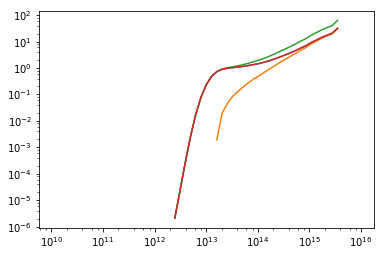

In [7]:
plt.plot(mbc, cen_hod)
plt.plot(mbc, sat_hod)
plt.plot(mbc, cen_hod+sat_hod)
plt.plot(mbc, tot_hod)
plt.loglog();

In [8]:
def ZhengCenHOD(mass, param_dict):
    
    logM = np.log10(mass)
    mean_ncen = 0.5*(1.0 + erf(
        (logM - param_dict['logMmin']) / param_dict['sigma_logM']))

    return mean_ncen

def ZhengSatHOD(mass, param_dict, mean_ncen = None):
    M0 = 10.**param_dict['logM0']
    M1 = 10.**param_dict['logM1']

    mean_nsat = np.zeros_like(mass)

    idx_nonzero = np.where(mass - M0 > 0)[0]
    
    mean_nsat[idx_nonzero] = ((mass[idx_nonzero] - M0)/M1)**param_dict['alpha']

    # If a central occupation model was passed to the constructor,
    # multiply mean_nsat by an overall factor of mean_ncen
    if mean_ncen is not None:
        # compatible with AB models
        mean_nsat *= mean_ncen

    return mean_nsat

def ZhengHOD(mass, param_dict):
    mean_ncen = ZhengCenHOD(mass, param_dict)
    mean_nsat = ZhengSatHOD(mass, param_dict, mean_ncen)
    return mean_ncen, mean_nsat

In [9]:
def calc_nd(mass,param_dict, mass_func):
    cen_hod, sat_hod = ZhengHOD(mass, param_dict)
    hod = cen_hod+sat_hod
    return np.dot(mass_func, hod)/(1000.0**3)

from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, mass, mass_func):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (calc_nd(mass, hod_params, mass_func) - 5e-4)**2

    res = minimize_scalar(func, bounds = (12,15), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    #print 'logMmin', res.x

In [10]:
with h5py.File('/home/users/swmclau2/scratch/PearceMCMC/HOD_MDPL2_wp_ds_rmin_0.5_HOD.hdf5', 'r') as f:
    hod_pnames =  f.attrs['param_names'][7:-1]
    chain = f['chain'][:, 7:-1]

In [11]:
param_dict = dict(zip(hod_pnames, chain[0]))

In [12]:
add_logMmin(param_dict, mbc, mass_func)

In [13]:
true_hod_params = {'alpha': 1.083, 'logM0': 13.2, 'logM1': 14.2, 'sigma_logM': 0.2}
true_hod_params['logMmin'] = 13.0 #approx, can fit if i have to

In [14]:
cat = TrainingBox(0)
cat.load(1.0, HOD='zheng07')

In [16]:
def add_logMmin2(cat, params, nd):
    def func(logMmin, hod_params):
        params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(params, min_ptcl=20) - nd)**2

    res = minimize_scalar(func, bounds = (12,16), args = (params,), options = {'maxiter':100}, method = 'Bounded')

     # assuming this doens't fail
    print 'logMmin', res.x
    params['logMmin'] = res.x


In [17]:
add_logMmin2(cat, true_hod_params, 5e-4)
cat.populate(true_hod_params)

logMmin 13.1366804182


(0.0001, 100.0)

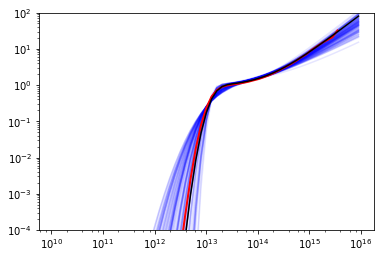

In [18]:
N = 100
idxs = np.random.choice(chain.shape[0], size=N, replace=False)

for i in idxs:
    param_dict = dict(zip(hod_pnames, chain[i]))
    add_logMmin(param_dict, mbc, mass_func)
    c, s = ZhengHOD(mbc, param_dict)
    plt.plot(mbc, c+s, alpha = 0.1, color = 'b')
    
plt.plot(mbc, tot_hod, color = 'r', lw =2)
c,s = ZhengHOD(mbc, true_hod_params)
plt.plot(mbc, c+s, color ='k')
plt.loglog();
plt.ylim([1e-4, 1e2])

In [19]:
catalog = np.load('/home/users/swmclau2/scratch/UniverseMachine/hod_catalog3.npy')

In [20]:
mdpl2_sat_mask = catalog['gal_type'] == 'satellites'

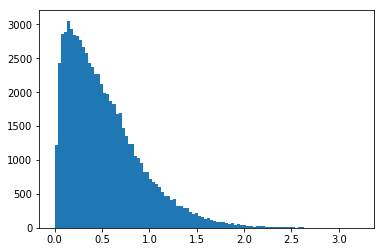

In [21]:
plt.hist(catalog[mdpl2_sat_mask]['host_centric_distance'], bins = 100);

In [22]:
gal_table = cat.model.mock.galaxy_table
sat_mask= gal_table['gal_type'] == 'satellites'

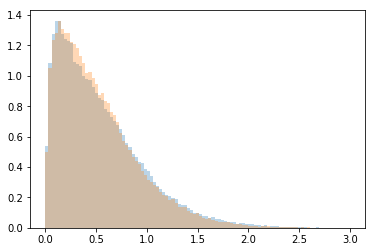

In [23]:
bins = np.linspace(0, 3, 100)
plt.hist(gal_table[sat_mask]['host_centric_distance'], bins = bins, alpha = 0.3, normed=True);
plt.hist(catalog[mdpl2_sat_mask]['host_centric_distance'], bins = bins, alpha = 0.3, normed=True);


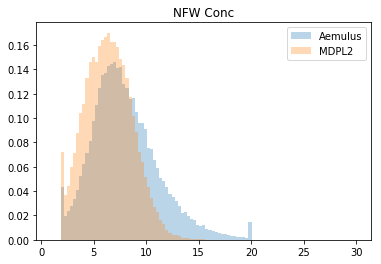

In [34]:
bins = np.linspace(1, 30, 100)
plt.hist(gal_table[sat_mask]['conc_NFWmodel'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(1.0*catalog[mdpl2_sat_mask]['conc_NFWmodel'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.title('NFW Conc')

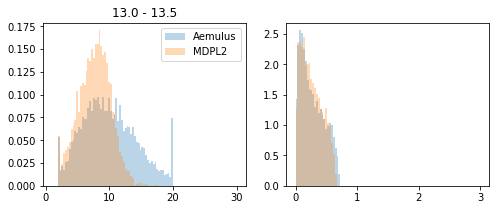

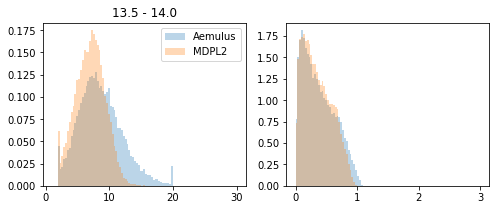

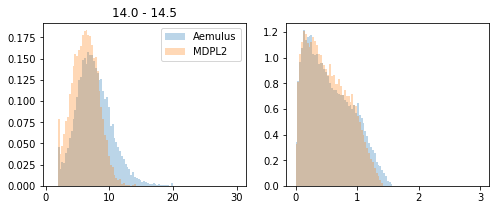

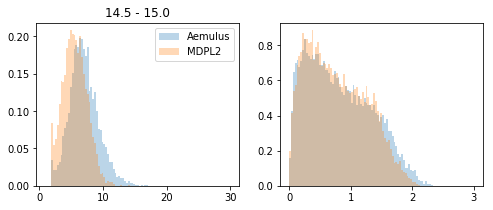

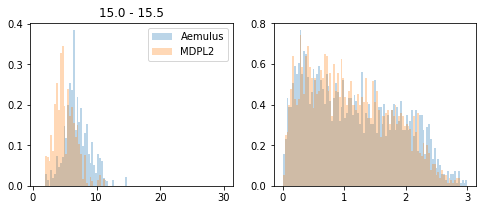

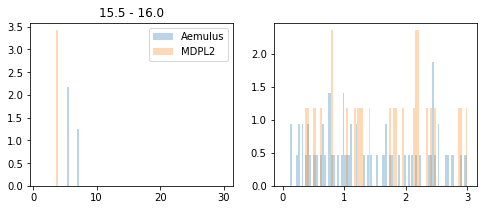

In [28]:
cbins = np.linspace(1, 30, 100)
rbins = np.linspace(0, 3, 100)

haloprop_bins = np.logspace(13,16,7)

for i,(mbl, mbh) in enumerate(zip(haloprop_bins[:-1], haloprop_bins[1:])):
    fig = plt.figure(figsize=(8,3))
    mass_cut = np.logical_and(mbl<gal_table['halo_mvir'], gal_table['halo_mvir']<mbh)
    mask = np.logical_and(mass_cut, sat_mask)
    plt.subplot(121)
    plt.hist(gal_table[mask]['conc_NFWmodel'], bins = cbins, alpha = 0.3, normed=True, label = 'Aemulus');
    
    mass_cut = np.logical_and(mbl<catalog['halo_mvir'], catalog['halo_mvir']<mbh)
    mask2 = np.logical_and(mass_cut, mdpl2_sat_mask)
    plt.hist(1.0*catalog[mask2]['conc_NFWmodel'], bins = cbins, alpha = 0.3, normed=True, label = 'MDPL2');
    plt.title('%0.1f - %0.1f'%(np.log10(mbl),np.log10(mbh)))
    plt.legend(loc='best')
    plt.subplot(122)
    plt.hist(gal_table[mask]['host_centric_distance'], bins = rbins, alpha = 0.3, normed=True);
    plt.hist(catalog[mask2]['host_centric_distance'], bins = rbins, alpha = 0.3, normed=True);

    plt.show()

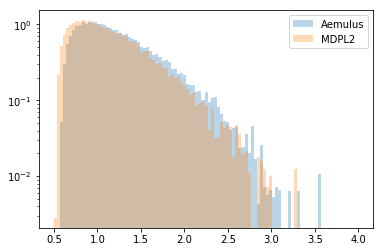

In [29]:
bins = np.linspace(0.5, 4, 100)
plt.hist(gal_table[sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(catalog[mdpl2_sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.yscale('log')